In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/clean_data/"

data = {}

for f in os.listdir(dirpath):
    if "cpm" in f:
        fullpath = f"{dirpath}{f}"
        key = f.split("_cpm")[0]
        df = pd.read_parquet(fullpath)
        print(f"{key} {df.shape=}")

        data[key] = df

print('done')

fed_f df.shape=(11290, 22047)
fasted_m df.shape=(10227, 22211)
fed_m df.shape=(9249, 21851)
fasted_f df.shape=(12171, 22861)
done


In [3]:
counts = []
condition  = []

for key, df in data.items():
    cdf = pd.DataFrame(df.sum(axis=0))
    cdf = cdf/df.shape[0] # normalize by the number of cells
    cdf.columns = [key]
    counts.append(cdf)
    condition.append(key)

counts = pd.concat(counts, ignore_index=False, axis=1)
counts = counts.reset_index(drop=False)
counts = counts.rename(columns={'index' : 'gene'})

# add quick aggregate measures
counts['sum'] = counts[condition].sum(axis=1)
counts['is_exp'] = np.where(counts['sum'] > 0, 1, 0)

print(f"{counts.shape=}")
print()
counts['is_exp'].value_counts()
print()

# extract genes with no expression, flag for removal
no_exp_genes = counts[counts['is_exp'] == 0]['gene'].to_list()
print(f"{len(no_exp_genes)=}")
counts.head()

counts.shape=(23366, 7)


len(no_exp_genes)=0


,gene,fed_f,fasted_m,fed_m,fasted_f,sum,is_exp
0,Xkr4,918.951477,937.148254,866.135071,868.761414,3590.996338,1
1,Gm1992,79.271484,85.585678,85.137329,103.238419,353.232910,1
2,Gm19938,42.937428,47.675449,41.305527,46.710930,178.629333,1
3,Rp1,0.673367,0.924722,0.789047,0.532697,2.919833,1
4,Sox17,1.695096,NaN,0.508423,NaN,2.203519,1


,gene,variable,value
47,Sst,fasted_f,117.723969
46,Gnrh1,fasted_f,0.980486
36,Nr5a1,fasted_f,8.660728
37,Slc32a1,fasted_f,23.427559
39,Gnrhr,fasted_f,0.572531


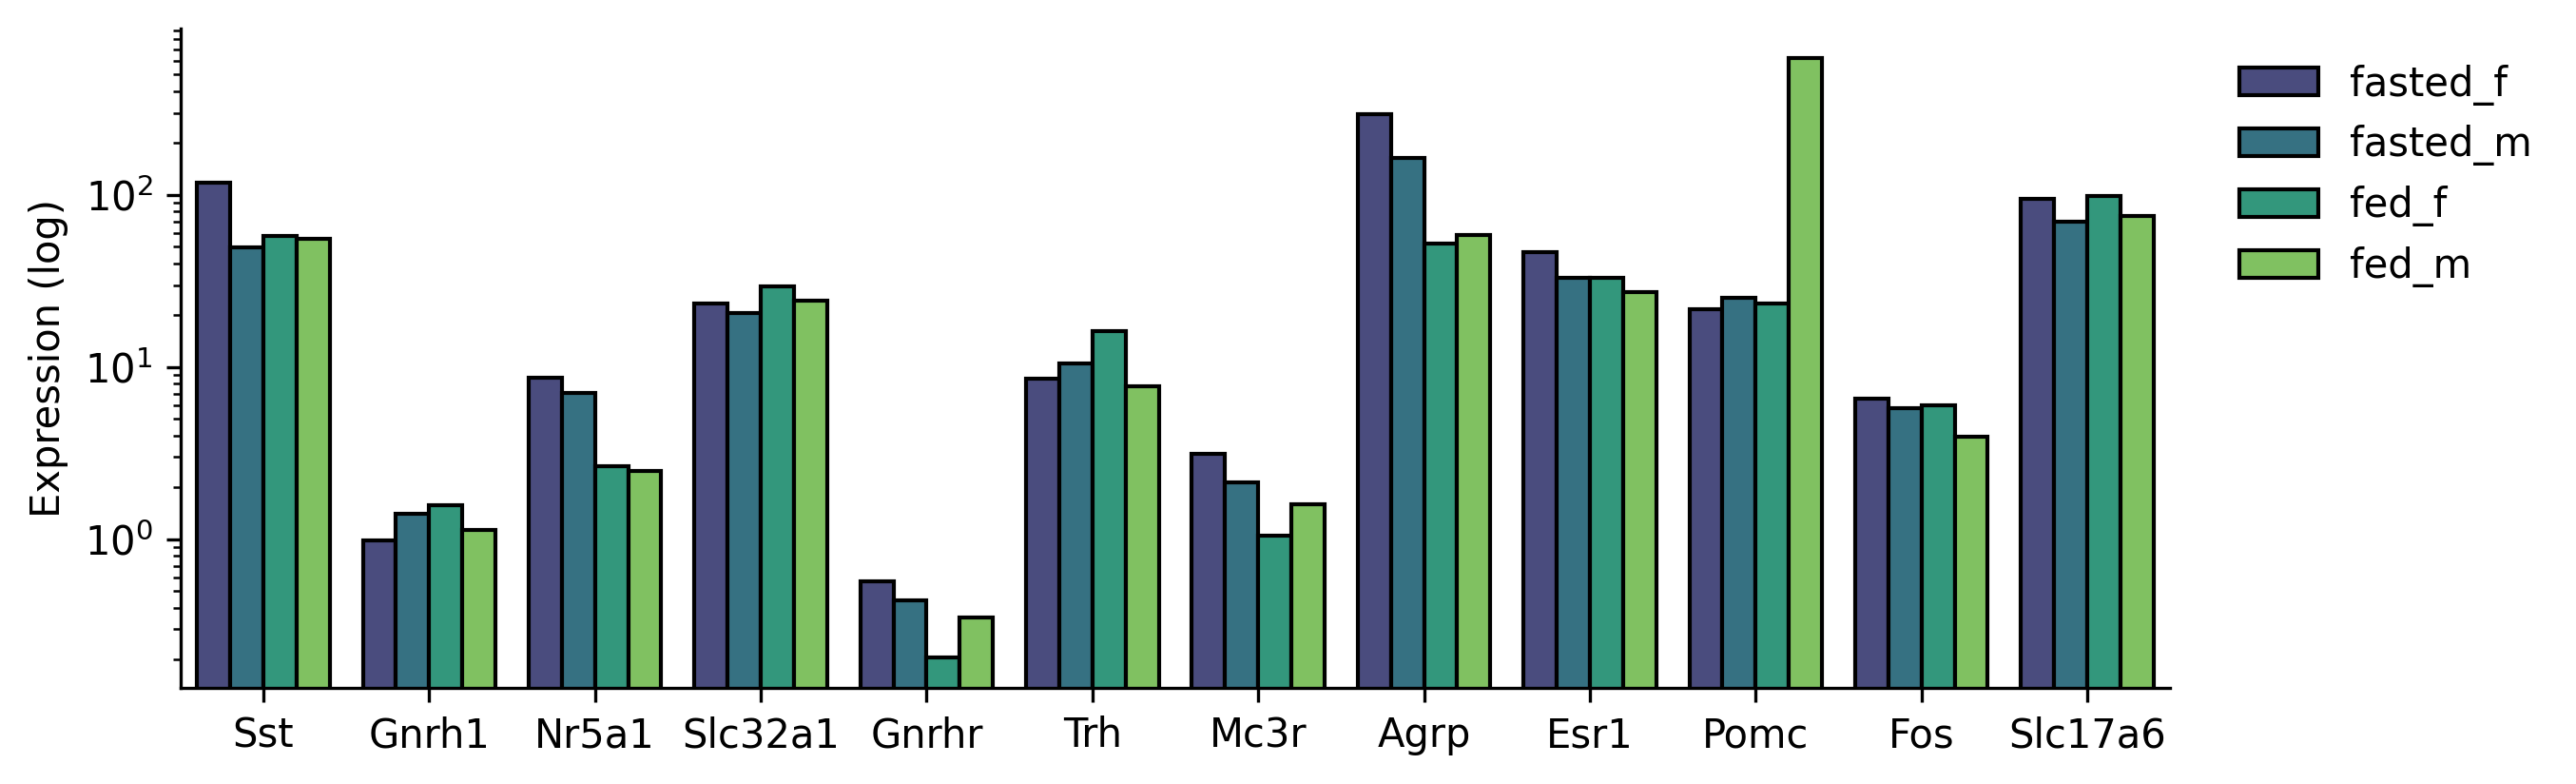

In [4]:
genes = [
    'Agrp',
    'Pomc',
    'Sst',
    'Kiss1',
    'Trh',
    'Gnrhr',
    'Gnrh1',
    'Slc32a1',
    'Slc17a6',
    'Mc3r',
    'Nr5a1',
    'Esr1',
    'Fos',
]


pdf = counts[counts['gene'].isin(genes)]

pdf = pd.melt(pdf, id_vars='gene', value_vars=condition)
pdf = pdf.sort_values(by='variable')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 3

sns.barplot(data=pdf, 
            x='gene',
            y='value',
            ec='k',
            hue='variable',
            palette='viridis')

plt.yscale("log")
plt.ylabel("Expression (log)")
plt.xlabel("")
sns.despine()

sns.move_legend(plt.gca(),
                loc='upper right',
                title="",
                frameon=False,
                bbox_to_anchor=(1.2, 1))

pdf.head()

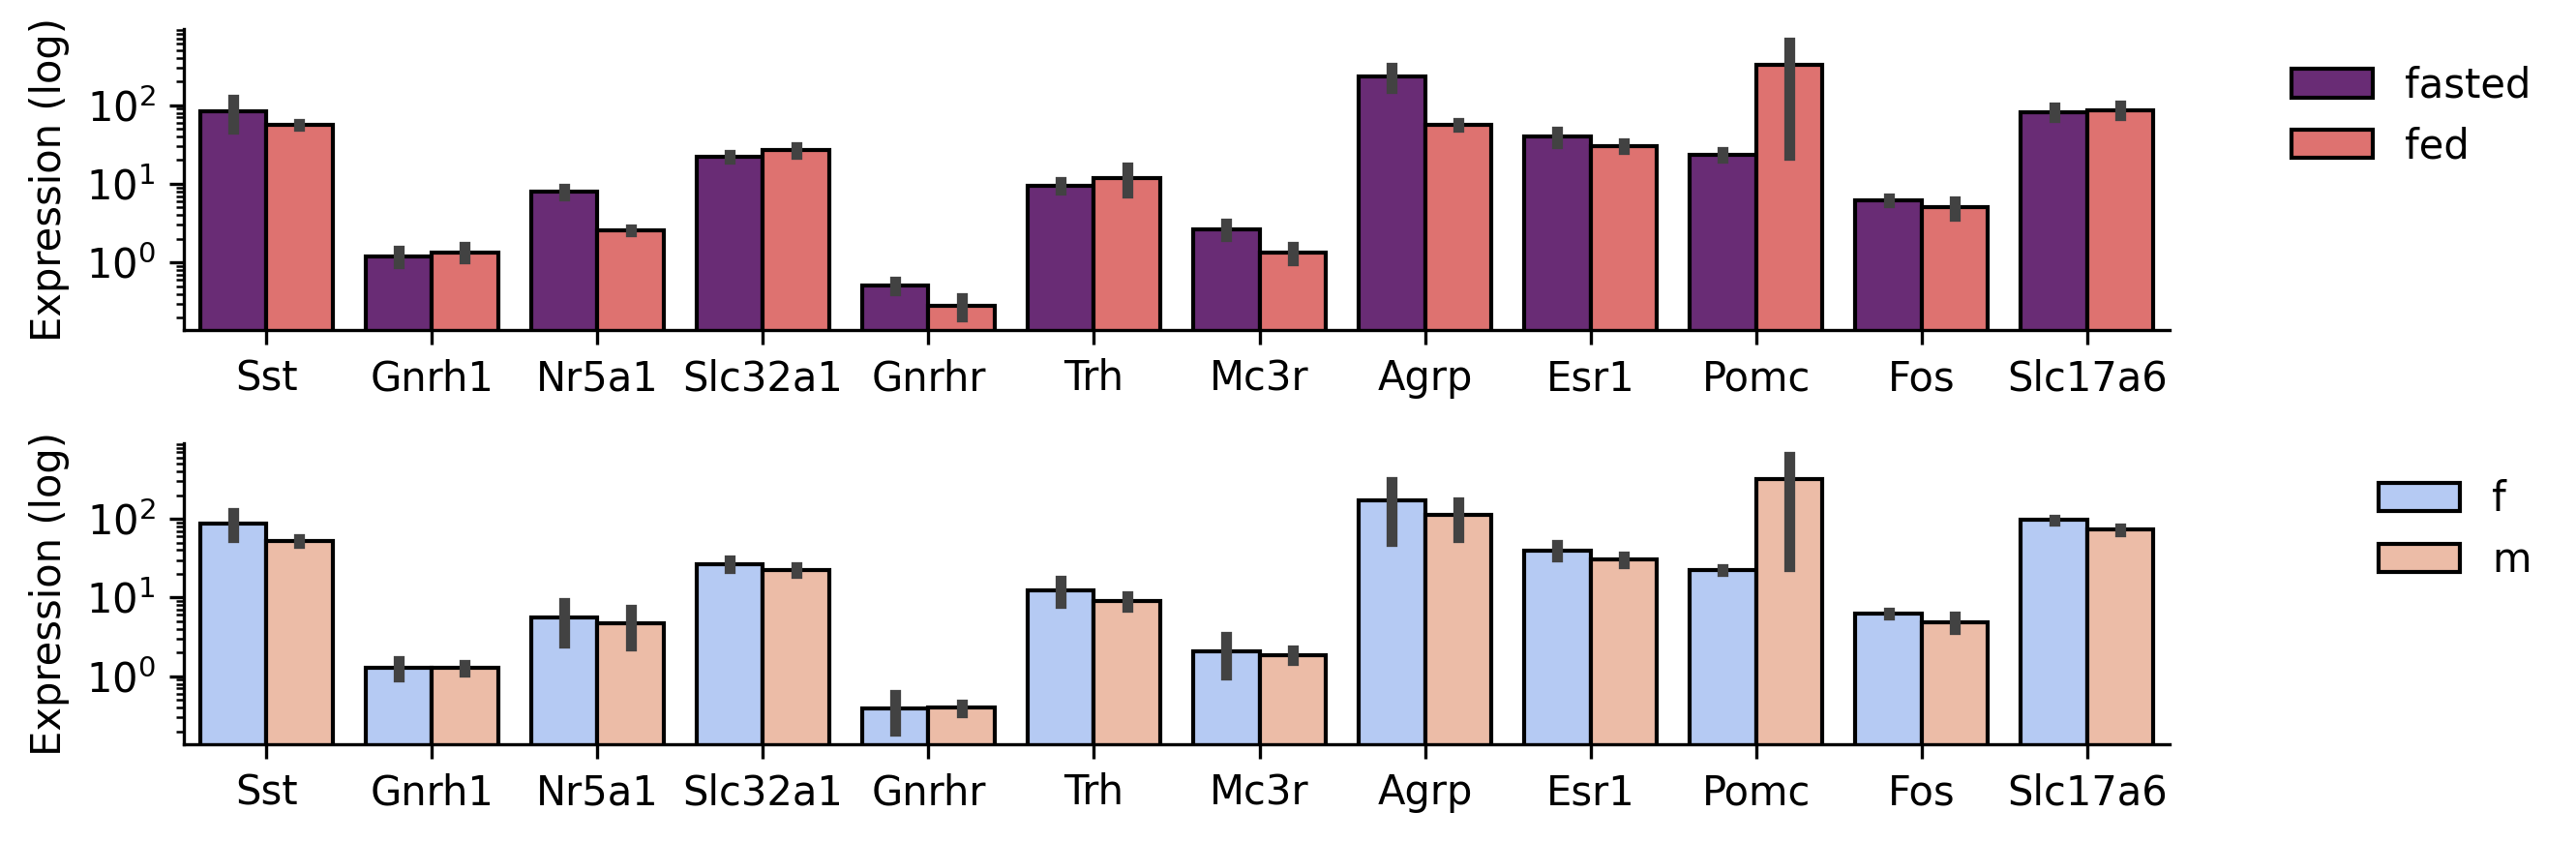

In [5]:
genes = [
    'Agrp',
    'Pomc',
    'Sst',
    'Kiss1',
    'Trh',
    'Gnrhr',
    'Gnrh1',
    'Slc32a1',
    'Slc17a6',
    'Mc3r',
    'Nr5a1',
    'Esr1',
    'Fos',
]


pdf = counts[counts['gene'].isin(genes)]


pdf = pd.melt(pdf, id_vars='gene', value_vars=condition)
pdf['condition'] = pdf['variable'].apply(lambda x: x.split("_")[0])
pdf['sex'] = pdf['variable'].apply(lambda x: x.split("_")[1])

pdf = pdf.sort_values(by='variable')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 3

fig, axs = plt.subplots(2, 1)


sns.barplot(data=pdf, 
            x='gene',
            y='value',
            ec='k',
            hue='condition',
            palette='magma',
            ax=axs[0])

axs[0].set_yscale("log")
axs[0].set_ylabel("Expression (log)")
axs[0].set_xlabel("")
sns.despine()

sns.move_legend(axs[0],
                loc='upper right',
                title="",
                frameon=False,
                bbox_to_anchor=(1.2, 1))

sns.barplot(data=pdf, 
            x='gene',
            y='value',
            ec='k',
            hue='sex',
            palette='coolwarm',
            ax=axs[1])

axs[1].set_yscale("log")
axs[1].set_ylabel("Expression (log)")
axs[1].set_xlabel("")
sns.despine()

sns.move_legend(axs[1],
                loc='upper right',
                title="",
                frameon=False,
                bbox_to_anchor=(1.2, 1))

plt.tight_layout()

In [6]:
genes = [
    'Agrp',
    'Pomc',
    'Sst',
    'Trh',
    'Gnrhr',
    'Gnrh1',
    'Slc32a1',
    'Slc17a6',
    'Mc3r',
    'Nr5a1',
    'Esr1',
    'Fos',
]

res = []

for g in genes:
    m = data['fed_m'][g].to_list() #  + data['fasted_m'][g].to_list()
    f = data['fed_f'][g].to_list() #  + data['fasted_f'][g].to_list()

    score, pval = scipy.stats.ranksums(m, f, alternative='two-sided')

    mean_m = np.mean(m)
    mean_f = np.mean(f)

    row = {
        'gene' : g,
        'score' : score,
        'pval' : pval,
        'mean_m' : mean_m,
        'mean_f' : mean_f,
    }
    res.append(row)

    
res = pd.DataFrame(res)
res.head()


,gene,score,pval,mean_m,mean_f
0,Agrp,0.780753,4.349475e-01,58.790987,52.449797
1,Pomc,90.113045,0.000000e+00,621.093503,23.348758
2,Sst,-1.016622,3.093334e-01,55.305983,57.839942
3,Trh,-5.263343,1.414593e-07,7.706686,16.244122
4,Gnrhr,0.100555,9.199039e-01,0.350629,0.205117
